In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [4]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteWVALBD/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [6]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [7]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [8]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], 0.8, 0.1, 0.1)

In [10]:
for data in train_dataset.take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


## Data Visualization

In [11]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpnn1f1d5ztfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


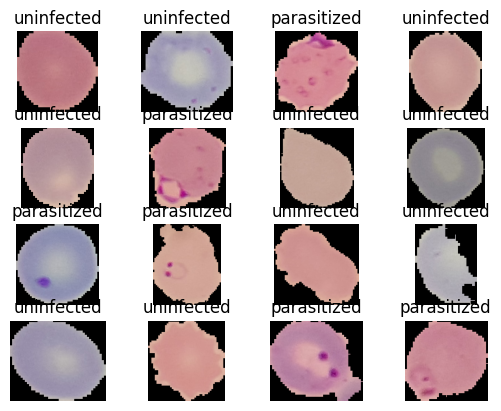

In [12]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label)) #here o means parasitized and 1 means uninfected
  plt.axis('off')

## Data Preprocessing

In [ ]:
# standardize means x - meu/delta
#normalization = x-x_min/x_max-x_min

In [14]:
IM_SIZE=224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [15]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [16]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [17]:
BATCH_SIZE=32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
BATCH_SIZE=32
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

convolutional neural network(CNN) is a neural network where each neuron in a layer does not connect to all neurons of next layer. so output of next layer does not depend on the input from all neurons in previous layer.

In [ ]:
# output size = input size -kernel size + 1

In [ ]:
# go to https://poloclub.github.io/cnn-explainer/ for more info

if a image is at the middle then many kernel touch it many times, but if image is at border then each kernel touches to once. to solve this we use padding.

striver control the step size. higher strider reduces output size

output_size = (input_size - kernel_size + 2*padding)/stride

here we use three matrices as input R, G, B.
we multiply each matrix with weight and the weighted sum equals the output

In [ ]:
# go to https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html for more info

dialation is used to increase the dimension of the image.
Go to https://github.com/vdumoulin/conv_arithmetic

## Model Creation

Here we are using lenet arch CNN
link = https://en.wikipedia.org/wiki/LeNet

In [21]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),


    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [22]:
tf.keras.utils.plot_model(lenet_model, show_shapes=True,)

## Funtional API

In [ ]:
#this is feature extractor funtional layer model

func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name="Input Image")
x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [ ]:
# this is feature extractor sequential apt model
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2)
])

feature_extractor_seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name="Input Image")
#we can use funtional or sequential api
#x = feature_extractor_model(func_input)
x = feature_extractor_seq_model(func_input)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name="Lenet Model")
lenet_model.summary()

Model: "Lenet Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dense_12 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_30 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                       

In [ ]:
tf.keras.utils.plot_model(lenet_model, show_shapes=True)

## Model Subclassing

In [ ]:
# this is subclass layer api
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name="Input Image")
x = feature_sub_classed(func_input)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name="Lenet Model")
lenet_model.summary()

Model: "Lenet Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_5 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_6 (Flatten)         (None, 46656)             0         
                                                                 
 dense_15 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_34 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 10)                

In [ ]:
class LenetModel(Layer):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation='sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)

    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name="Input_Image")


lenet_sub_classed = LenetModel()
func_output = lenet_sub_classed(func_input)
lenet_model = Model(func_input, func_output, name="Subclassed_Lenet_Model")
lenet_model.summary()

Model: "Subclassed_Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 lenet_model_6 (LenetModel)  (None, 1)                 4668649   
                                                                 
Total params: 4668649 (17.81 MB)
Trainable params: 4668381 (17.81 MB)
Non-trainable params: 268 (1.05 KB)
_________________________________________________________________


In [ ]:
# go to https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer
class NeuralDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralDense, self).__init__()
    self.output_units = output_units
    self.activation = activation
  def build(self, input_features_shape):
    self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer = "random_normal", trainable=True)
    self.b = self.add_weight(shape=(self.output_units, ), initializer="random_normal", trainable=True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if(self.activation=="relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation=="sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output


In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),


    NeuralDense(100, activation='relu'),
    BatchNormalization(),
    NeuralDense(10, activation='relu'),
    BatchNormalization(),
    NeuralDense(1, activation='sigmoid'),
])

lenet_custom_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_86 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_87 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

## Model Training

In [23]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [24]:
lenet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

In [26]:
# this will show error if val_dataset is not shuffeled, and image is not resized and rescaled
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 885s 1s/step - loss: 0.3120 - tp: 9788.0000 - fp: 1580.0000 - tn: 9440.0000 - fn: 1238.0000 - accuracy: 0.8722 - precision: 0.8610 - recall: 0.8877 - auc: 0.9388 - val_loss: 0.1869 - val_tp: 1325.0000 - val_fp: 111.0000 - val_tn: 1256.0000 - val_fn: 63.0000 - val_accuracy: 0.9368 - val_precision: 0.9227 - val_recall: 0.9546 - val_auc: 0.9782
Epoch 2/5
689/689 [==============================] - 872s 1s/step - loss: 0.1988 - tp: 10422.0000 - fp: 854.0000 - tn: 10169.0000 - fn: 601.0000 - accuracy: 0.9340 - precision: 0.9243 - recall: 0.9455 - auc: 0.9696 - val_loss: 0.2087 - val_tp: 1359.0000 - val_fp: 152.0000 - val_tn: 1216.0000 - val_fn: 28.0000 - val_accuracy: 0.9347 - val_precision: 0.8994 - val_recall: 0.9798 - val_auc: 0.9754
Epoch 3/5
689/689 [==============================] - 832s 1s/step - loss: 0.3432 - tp: 9544.0000 - fp: 1938.0000 - tn: 9085.0000 - fn: 1479.0000 - accuracy: 0.8450 - precision: 0.8312 - recall: 0.8658 - auc

## custom Layer

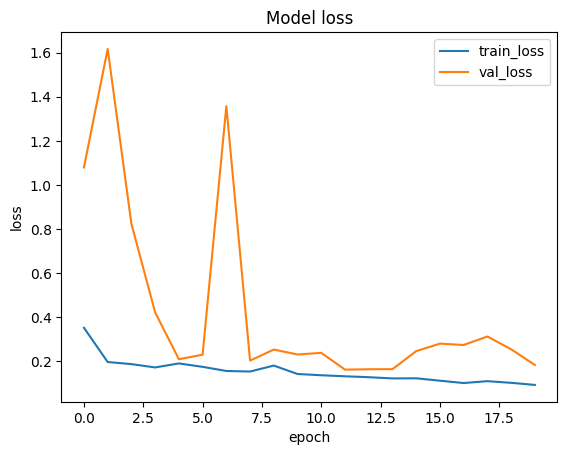

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

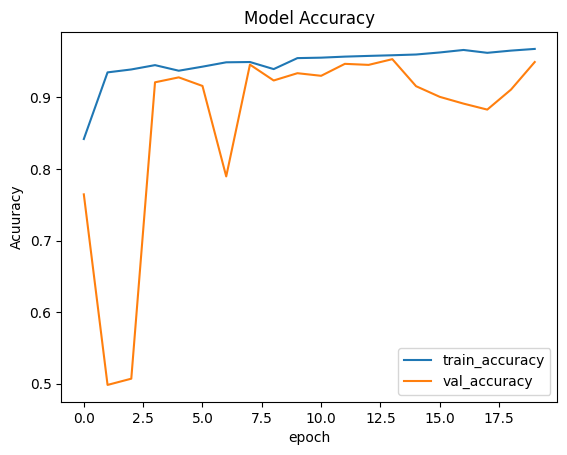

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Acuuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Model evaluation

In [ ]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.1999 - accuracy: 0.9402


[0.1998920440673828, 0.9401523470878601]

In [ ]:
def parasite_or_not(x):
  if x<0.5:
    return "P"
  else:
    return "U"

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'U'

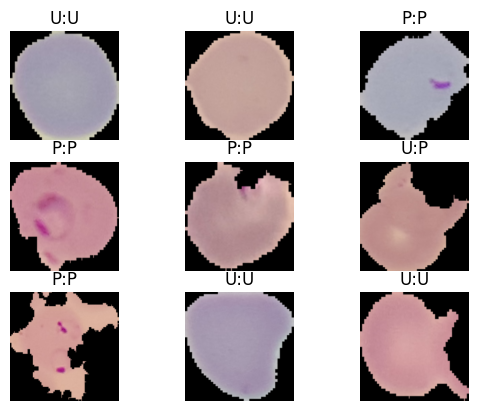

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image, verbose=0)[0][0])))
  plt.axis('off')

## Loding and Saving

In [ ]:
lenet_model.save("lenet")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
lenet_model.save("lenet.keras") # .hdf5 is old now

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet.keras")
lenet_loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
lenet_model.save_weights("weights/lenet_weights")

In [ ]:
lenet_weights_model = lenet_model.load_weights("weights/lenet_weights")
lenet_weights_model

## Saving to and Loading from Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/CV/03Malaria/lenet/

In [ ]:
!cp -r /content/weights/ /content/drive/MyDrive/CV/03Malaria/weights/

In [ ]:
!cp /content/lenet.keras /content/drive/MyDrive/CV/03Malaria/